# Setup

In [1]:
# Detect if we're running in Google Colab
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
except:
  IN_COLAB = False

if IN_COLAB:
  # %pip install nnsight
  %pip install circuitsvis
  %pip install transformer_lens
  %pip install einops
  %pip install git+https://github.com/neelnanda-io/neel-plotly.git
  %pip install kaleido

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-leknxam7
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-leknxam7
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done


## imports

In [ ]:
import circuitsvis as cv
import einops
import torch
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

# messing around

In [ ]:
torch.set_grad_enabled(False)
print("turn off gradients to save memory")

turn off gradients to save memory


In [ ]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [ ]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

# Get the default device used
device: torch.device = utils.get_device()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
example_prompt = "I am going to feed the group of cat"
example_answer = "s"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'I', ' am', ' going', ' to', ' feed', ' the', ' group', ' of', ' cat']
Tokenized answer: [' s']


Performance on answer token:
Rank: 182      Logit:  7.48 Prob:  0.06% Token: | s|

Top 0th token. Logit: 12.33 Prob:  7.07% Token: | lovers|
Top 1th token. Logit: 12.23 Prob:  6.37% Token: |fish|
Top 2th token. Logit: 12.15 Prob:  5.90% Token: | people|
Top 3th token. Logit: 11.89 Prob:  4.53% Token: | owners|
Top 4th token. Logit: 11.76 Prob:  3.97% Token: |-|
Top 5th token. Logit: 11.63 Prob:  3.50% Token: | that|
Top 6th token. Logit: 11.61 Prob:  3.44% Token: |chers|
Top 7th token. Logit: 11.10 Prob:  2.07% Token: |girls|
Top 8th token. Logit: 10.88 Prob:  1.66% Token: |'s|
Top 9th token. Logit: 10.70 Prob:  1.38% Token: | who|


Ranks of the answer tokens: [(' s', 182)]

In [ ]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
names = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]
# List of prompts
prompts = []
# List of answers, in the format (correct, incorrect)
answers = []
# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = []
for i in range(len(prompt_format)):
    for j in range(2):
        answers.append((names[i][j], names[i][1 - j]))
        answer_tokens.append(
            (
                model.to_single_token(answers[-1][0]),
                model.to_single_token(answers[-1][1]),
            )
        )
        # Insert the *incorrect* answer to the prompt, making the correct answer the indirect object.
        prompts.append(prompt_format[i].format(answers[-1][1]))
answer_tokens = torch.tensor(answer_tokens).to(device)
print(prompts)
print(answers)

['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to', 'When Tom and James went to the park, James gave the ball to', 'When Tom and James went to the park, Tom gave the ball to', 'When Dan and Sid went to the shops, Sid gave an apple to', 'When Dan and Sid went to the shops, Dan gave an apple to', 'After Martin and Amy went to the park, Amy gave a drink to', 'After Martin and Amy went to the park, Martin gave a drink to']
[(' Mary', ' John'), (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]


In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


print(
    "Per prompt logit difference:",
    logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(logits_to_ave_logit_diff(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([3.3370, 3.2020, 2.7090, 3.7970, 1.7200, 5.2810, 2.6010, 5.7670])
Average logit difference: 3.552


In [ ]:
x = model.tokens_to_residual_directions(answer_tokens)[2]
scatter(x[0], x[1])

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([8, 2, 768])
Logit difference directions shape: torch.Size([8, 768])


In [ ]:
def f(x, y) -> str:
  return f"{x} is greater than {y} means {y} is not"

In [ ]:
# sentences of the form (to be completed):
# - thing1 is bigger than thing2, so thing2 is
# - x is greater than y

In [ ]:
test_prompt = "thing1 is bigger than thing2, so thing2 is"
test_completion = "smaller than thing1"
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'thing', '1', ' is', ' bigger', ' than', ' thing', '2', ',', ' so', ' thing', '2', ' is']
Tokenized answer: [' smaller', ' than', ' thing', '1']


Performance on answer token:
Rank: 1        Logit: 14.60 Prob: 12.51% Token: | smaller|

Top 0th token. Logit: 15.97 Prob: 49.27% Token: | bigger|
Top 1th token. Logit: 14.60 Prob: 12.51% Token: | smaller|
Top 2th token. Logit: 13.60 Prob:  4.61% Token: | larger|
Top 3th token. Logit: 12.49 Prob:  1.51% Token: | a|
Top 4th token. Logit: 12.37 Prob:  1.35% Token: | more|
Top 5th token. Logit: 12.17 Prob:  1.11% Token: | the|
Top 6th token. Logit: 12.12 Prob:  1.05% Token: | not|
Top 7th token. Logit: 12.11 Prob:  1.04% Token: | big|
Top 8th token. Logit: 11.85 Prob:  0.81% Token: | also|
Top 9th token. Logit: 11.84 Prob:  0.79% Token: | much|


Performance on answer token:
Rank: 0        Logit: 17.25 Prob: 70.14% Token: | than|

Top 0th token. Logit: 17.25 Prob: 70.14% Token: | than|
Top 1th token. Logit: 15.72 Prob: 15.15% Token: |.|
Top 2th token. Logit: 13.97 Prob:  2.63% Token: |,|
Top 3th token. Logit: 13.59 Prob:  1.80% Token: |
|
Top 4th token. Logit: 12.93 Prob:  0.93% Token: | then|
Top 5th token. Logit: 12.74 Prob:  0.77% Token: | and|
Top 6th token. Logit: 12.60 Prob:  0.67% Token: | too|
Top 7th token. Logit: 12.29 Prob:  0.49% Token: | (|
Top 8th token. Logit: 11.59 Prob:  0.24% Token: | because|
Top 9th token. Logit: 11.59 Prob:  0.24% Token: | in|


Performance on answer token:
Rank: 0        Logit: 17.82 Prob: 88.27% Token: | thing|

Top 0th token. Logit: 17.82 Prob: 88.27% Token: | thing|
Top 1th token. Logit: 13.51 Prob:  1.19% Token: | Thing|
Top 2th token. Logit: 12.92 Prob:  0.66% Token: | things|
Top 3th token. Logit: 12.88 Prob:  0.63% Token: | anything|
Top 4th token. Logit: 12.79 Prob:  0.58% Token: | it|
Top 5th token. Logit: 12.67 Prob:  0.51% Token: | stuff|
Top 6th token. Logit: 12.42 Prob:  0.40% Token: | something|
Top 7th token. Logit: 12.07 Prob:  0.28% Token: |thing|
Top 8th token. Logit: 12.00 Prob:  0.26% Token: | the|
Top 9th token. Logit: 11.88 Prob:  0.23% Token: | what|


Performance on answer token:
Rank: 0        Logit: 19.00 Prob: 49.36% Token: |1|

Top 0th token. Logit: 19.00 Prob: 49.36% Token: |1|
Top 1th token. Logit: 18.83 Prob: 41.57% Token: |3|
Top 2th token. Logit: 16.97 Prob:  6.47% Token: |2|
Top 3th token. Logit: 14.63 Prob:  0.62% Token: |4|
Top 4th token. Logit: 14.63 Prob:  0.62% Token: |5|
Top 5th token. Logit: 13.41 Prob:  0.18% Token: | 1|
Top 6th token. Logit: 13.40 Prob:  0.18% Token: |0|
Top 7th token. Logit: 13.01 Prob:  0.12% Token: | 3|
Top 8th token. Logit: 12.61 Prob:  0.08% Token: |7|
Top 9th token. Logit: 12.04 Prob:  0.05% Token: |6|


Ranks of the answer tokens: [(' smaller', 1), (' than', 0), (' thing', 0), ('1', 0)]

In [ ]:
test_prompt = "Andrew is smaller than Byron. Byron is not"
test_completion = "smaller than Andrew"
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Andrew', ' is', ' smaller', ' than', ' Byron', '.', ' Byron', ' is', ' not']
Tokenized answer: [' smaller', ' than', ' Andrew']


Performance on answer token:
Rank: 4        Logit: 14.04 Prob:  4.90% Token: | smaller|

Top 0th token. Logit: 15.29 Prob: 17.08% Token: |.|
Top 1th token. Logit: 14.71 Prob:  9.61% Token: | big|
Top 2th token. Logit: 14.34 Prob:  6.64% Token: | bigger|
Top 3th token. Logit: 14.19 Prob:  5.71% Token: | as|
Top 4th token. Logit: 14.04 Prob:  4.90% Token: | smaller|
Top 5th token. Logit: 14.03 Prob:  4.87% Token: | a|
Top 6th token. Logit: 13.45 Prob:  2.72% Token: | small|
Top 7th token. Logit: 13.41 Prob:  2.61% Token: | large|
Top 8th token. Logit: 13.36 Prob:  2.47% Token: | much|
Top 9th token. Logit: 13.30 Prob:  2.33% Token: | larger|


Performance on answer token:
Rank: 0        Logit: 19.60 Prob: 82.89% Token: | than|

Top 0th token. Logit: 19.60 Prob: 82.89% Token: | than|
Top 1th token. Logit: 17.31 Prob:  8.36% Token: |.|
Top 2th token. Logit: 15.87 Prob:  1.98% Token: |,|
Top 3th token. Logit: 15.13 Prob:  0.95% Token: | then|
Top 4th token. Logit: 14.87 Prob:  0.73% Token: | but|
Top 5th token. Logit: 14.76 Prob:  0.65% Token: | at|
Top 6th token. Logit: 14.44 Prob:  0.48% Token: | and|
Top 7th token. Logit: 14.23 Prob:  0.39% Token: | because|
Top 8th token. Logit: 13.89 Prob:  0.27% Token: | in|
Top 9th token. Logit: 13.66 Prob:  0.22% Token: | like|


Performance on answer token:
Rank: 0        Logit: 17.50 Prob: 81.42% Token: | Andrew|

Top 0th token. Logit: 17.50 Prob: 81.42% Token: | Andrew|
Top 1th token. Logit: 12.70 Prob:  0.67% Token: | Byron|
Top 2th token. Logit: 12.60 Prob:  0.60% Token: | Andy|
Top 3th token. Logit: 12.49 Prob:  0.54% Token: | him|
Top 4th token. Logit: 12.26 Prob:  0.43% Token: | the|
Top 5th token. Logit: 11.99 Prob:  0.33% Token: | his|
Top 6th token. Logit: 11.79 Prob:  0.27% Token: | a|
Top 7th token. Logit: 11.75 Prob:  0.26% Token: | Alex|
Top 8th token. Logit: 11.65 Prob:  0.23% Token: | Nick|
Top 9th token. Logit: 11.56 Prob:  0.22% Token: | Anthony|


Ranks of the answer tokens: [(' smaller', 4), (' than', 0), (' Andrew', 0)]

In [ ]:
# goal: what's up with this pathology where it completes to "byron is not <.>". It doesn't make semantic sense.

In [ ]:
test_prompt = "Andrew is bluer than Byron. Byron is not.."
test_completion = "redder than Andrew"
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Andrew', ' is', ' bl', 'uer', ' than', ' Byron', '.', ' Byron', ' is', ' not', '..']
Tokenized answer: [' red', 'der', ' than', ' Andrew']


Performance on answer token:
Rank: 1870     Logit:  4.26 Prob:  0.00% Token: | red|

Top 0th token. Logit: 11.94 Prob:  8.67% Token: |
|
Top 1th token. Logit: 11.31 Prob:  4.60% Token: | Byron|
Top 2th token. Logit: 11.21 Prob:  4.16% Token: |well|
Top 3th token. Logit: 11.03 Prob:  3.48% Token: | well|
Top 4th token. Logit: 10.80 Prob:  2.76% Token: | he|
Top 5th token. Logit: 10.78 Prob:  2.71% Token: | He|
Top 6th token. Logit: 10.56 Prob:  2.17% Token: | Andrew|
Top 7th token. Logit: 10.25 Prob:  1.59% Token: | I|
Top 8th token. Logit: 10.06 Prob:  1.32% Token: |he|
Top 9th token. Logit:  9.75 Prob:  0.96% Token: | you|


Performance on answer token:
Rank: 1        Logit: 14.08 Prob: 13.33% Token: |der|

Top 0th token. Logit: 14.50 Prob: 20.32% Token: |.|
Top 1th token. Logit: 14.08 Prob: 13.33% Token: |der|
Top 2th token. Logit: 13.60 Prob:  8.28% Token: |-|
Top 3th token. Logit: 13.04 Prob:  4.73% Token: |,|
Top 4th token. Logit: 12.72 Prob:  3.43% Token: |neck|
Top 5th token. Logit: 12.56 Prob:  2.91% Token: | and|
Top 6th token. Logit: 12.55 Prob:  2.89% Token: |ne|
Top 7th token. Logit: 12.41 Prob:  2.51% Token: | in|
Top 8th token. Logit: 12.30 Prob:  2.25% Token: |head|
Top 9th token. Logit: 11.99 Prob:  1.66% Token: | hot|


Performance on answer token:
Rank: 0        Logit: 15.82 Prob: 51.96% Token: | than|

Top 0th token. Logit: 15.82 Prob: 51.96% Token: | than|
Top 1th token. Logit: 14.94 Prob: 21.59% Token: |.|
Top 2th token. Logit: 13.29 Prob:  4.15% Token: |,|
Top 3th token. Logit: 12.72 Prob:  2.35% Token: |..|
Top 4th token. Logit: 12.64 Prob:  2.17% Token: | and|
Top 5th token. Logit: 11.98 Prob:  1.11% Token: |?|
Top 6th token. Logit: 11.61 Prob:  0.77% Token: |!|
Top 7th token. Logit: 11.59 Prob:  0.76% Token: |-|
Top 8th token. Logit: 11.58 Prob:  0.75% Token: | like|
Top 9th token. Logit: 11.57 Prob:  0.74% Token: | in|


Performance on answer token:
Rank: 0        Logit: 15.07 Prob: 46.23% Token: | Andrew|

Top 0th token. Logit: 15.07 Prob: 46.23% Token: | Andrew|
Top 1th token. Logit: 12.79 Prob:  4.74% Token: | Byron|
Top 2th token. Logit: 11.87 Prob:  1.89% Token: | Andy|
Top 3th token. Logit: 11.72 Prob:  1.63% Token: | he|
Top 4th token. Logit: 11.55 Prob:  1.38% Token: | the|
Top 5th token. Logit: 11.47 Prob:  1.27% Token: | him|
Top 6th token. Logit: 11.18 Prob:  0.95% Token: | his|
Top 7th token. Logit: 11.00 Prob:  0.79% Token: | a|
Top 8th token. Logit: 10.96 Prob:  0.76% Token: | you|
Top 9th token. Logit: 10.69 Prob:  0.58% Token: | I|


Ranks of the answer tokens: [(' red', 1870), ('der', 1), (' than', 0), (' Andrew', 0)]

In [ ]:
test_prompt = "Andrew is bluer than Byron. Byron is not"
test_completion = "redder than Andrew"
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Andrew', ' is', ' bl', 'uer', ' than', ' Byron', '.', ' Byron', ' is', ' not']
Tokenized answer: [' red', 'der', ' than', ' Andrew']


Performance on answer token:
Rank: 447      Logit:  7.96 Prob:  0.01% Token: | red|

Top 0th token. Logit: 15.33 Prob: 23.08% Token: |.|
Top 1th token. Logit: 14.32 Prob:  8.34% Token: | bl|
Top 2th token. Logit: 14.29 Prob:  8.09% Token: | a|
Top 3th token. Logit: 13.41 Prob:  3.37% Token: | as|
Top 4th token. Logit: 13.30 Prob:  3.03% Token: | so|
Top 5th token. Logit: 13.17 Prob:  2.65% Token: |,|
Top 6th token. Logit: 13.15 Prob:  2.60% Token: | the|
Top 7th token. Logit: 12.55 Prob:  1.42% Token: | just|
Top 8th token. Logit: 12.50 Prob:  1.36% Token: | like|
Top 9th token. Logit: 12.06 Prob:  0.88% Token: | an|


Performance on answer token:
Rank: 5        Logit: 13.55 Prob:  3.00% Token: |der|

Top 0th token. Logit: 15.56 Prob: 22.21% Token: |.|
Top 1th token. Logit: 15.50 Prob: 21.07% Token: |-|
Top 2th token. Logit: 14.69 Prob:  9.33% Token: |,|
Top 3th token. Logit: 14.13 Prob:  5.31% Token: | and|
Top 4th token. Logit: 13.78 Prob:  3.75% Token: | as|
Top 5th token. Logit: 13.55 Prob:  3.00% Token: |der|
Top 6th token. Logit: 13.55 Prob:  2.98% Token: | hot|
Top 7th token. Logit: 13.54 Prob:  2.96% Token: | in|
Top 8th token. Logit: 13.34 Prob:  2.41% Token: | like|
Top 9th token. Logit: 13.23 Prob:  2.17% Token: |ne|


Performance on answer token:
Rank: 1        Logit: 16.43 Prob: 33.24% Token: | than|

Top 0th token. Logit: 16.53 Prob: 36.62% Token: |.|
Top 1th token. Logit: 16.43 Prob: 33.24% Token: | than|
Top 2th token. Logit: 15.08 Prob:  8.61% Token: |,|
Top 3th token. Logit: 14.08 Prob:  3.17% Token: | and|
Top 4th token. Logit: 13.53 Prob:  1.84% Token: | or|
Top 5th token. Logit: 13.33 Prob:  1.50% Token: | in|
Top 6th token. Logit: 13.00 Prob:  1.08% Token: | like|
Top 7th token. Logit: 12.63 Prob:  0.74% Token: |;|
Top 8th token. Logit: 12.46 Prob:  0.63% Token: |-|
Top 9th token. Logit: 12.31 Prob:  0.54% Token: | but|


Performance on answer token:
Rank: 0        Logit: 17.04 Prob: 78.96% Token: | Andrew|

Top 0th token. Logit: 17.04 Prob: 78.96% Token: | Andrew|
Top 1th token. Logit: 12.94 Prob:  1.30% Token: | Andy|
Top 2th token. Logit: 12.84 Prob:  1.18% Token: | Byron|
Top 3th token. Logit: 12.26 Prob:  0.66% Token: | him|
Top 4th token. Logit: 12.15 Prob:  0.59% Token: | he|
Top 5th token. Logit: 12.13 Prob:  0.58% Token: | the|
Top 6th token. Logit: 11.94 Prob:  0.48% Token: | his|
Top 7th token. Logit: 11.63 Prob:  0.35% Token: | a|
Top 8th token. Logit: 11.45 Prob:  0.29% Token: | Andrews|
Top 9th token. Logit: 11.17 Prob:  0.22% Token: | Alex|


Ranks of the answer tokens: [(' red', 447), ('der', 5), (' than', 1), (' Andrew', 0)]

In [ ]:
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'thing', '1', ' is', ' bigger', ' than', ' thing', '2', '.', ' Thing', '2', ' is', ' not']
Tokenized answer: [' smaller', ' than', ' thing', '1']


Performance on answer token:
Rank: 4        Logit: 11.99 Prob:  3.15% Token: | smaller|

Top 0th token. Logit: 13.99 Prob: 23.18% Token: | bigger|
Top 1th token. Logit: 12.76 Prob:  6.82% Token: | big|
Top 2th token. Logit: 12.60 Prob:  5.77% Token: | a|
Top 3th token. Logit: 12.05 Prob:  3.34% Token: | as|
Top 4th token. Logit: 11.99 Prob:  3.15% Token: | smaller|
Top 5th token. Logit: 11.85 Prob:  2.74% Token: | the|
Top 6th token. Logit: 11.71 Prob:  2.39% Token: | larger|
Top 7th token. Logit: 11.30 Prob:  1.58% Token: | really|
Top 8th token. Logit: 11.28 Prob:  1.54% Token: |.|
Top 9th token. Logit: 11.03 Prob:  1.20% Token: | that|


Performance on answer token:
Rank: 0        Logit: 18.73 Prob: 89.84% Token: | than|

Top 0th token. Logit: 18.73 Prob: 89.84% Token: | than|
Top 1th token. Logit: 15.77 Prob:  4.62% Token: |.|
Top 2th token. Logit: 14.39 Prob:  1.17% Token: |,|
Top 3th token. Logit: 13.92 Prob:  0.73% Token: | then|
Top 4th token. Logit: 12.98 Prob:  0.29% Token: | because|
Top 5th token. Logit: 12.72 Prob:  0.22% Token: | at|
Top 6th token. Logit: 12.70 Prob:  0.22% Token: |;|
Top 7th token. Logit: 12.69 Prob:  0.21% Token: | but|
Top 8th token. Logit: 12.50 Prob:  0.18% Token: | and|
Top 9th token. Logit: 12.28 Prob:  0.14% Token: | in|


Performance on answer token:
Rank: 0        Logit: 17.07 Prob: 76.00% Token: | thing|

Top 0th token. Logit: 17.07 Prob: 76.00% Token: | thing|
Top 1th token. Logit: 15.23 Prob: 12.01% Token: | Thing|
Top 2th token. Logit: 12.90 Prob:  1.18% Token: | anything|
Top 3th token. Logit: 12.07 Prob:  0.51% Token: | the|
Top 4th token. Logit: 12.03 Prob:  0.49% Token: | things|
Top 5th token. Logit: 11.87 Prob:  0.42% Token: | something|
Top 6th token. Logit: 11.71 Prob:  0.36% Token: | what|
Top 7th token. Logit: 11.71 Prob:  0.36% Token: | it|
Top 8th token. Logit: 11.23 Prob:  0.22% Token: | stuff|
Top 9th token. Logit: 11.22 Prob:  0.22% Token: |thing|


Performance on answer token:
Rank: 0        Logit: 18.80 Prob: 53.67% Token: |1|

Top 0th token. Logit: 18.80 Prob: 53.67% Token: |1|
Top 1th token. Logit: 18.34 Prob: 33.91% Token: |3|
Top 2th token. Logit: 17.05 Prob:  9.30% Token: |2|
Top 3th token. Logit: 14.50 Prob:  0.72% Token: |5|
Top 4th token. Logit: 14.43 Prob:  0.68% Token: |4|
Top 5th token. Logit: 13.70 Prob:  0.33% Token: | 1|
Top 6th token. Logit: 13.26 Prob:  0.21% Token: |0|
Top 7th token. Logit: 13.11 Prob:  0.18% Token: | 3|
Top 8th token. Logit: 12.45 Prob:  0.09% Token: |7|
Top 9th token. Logit: 12.02 Prob:  0.06% Token: |6|


Ranks of the answer tokens: [(' smaller', 4), (' than', 0), (' thing', 0), ('1', 0)]

NoneType

In [ ]:
test_prompt = "thing1 is bigger than thing2. Thing2 is not"
test_completion = "smaller than thing1"
utils.test_prompt(test_prompt, test_completion, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'thing', '1', ' is', ' bigger', ' than', ' thing', '2', '.', ' Thing', '2', ' is', ' not']
Tokenized answer: [' smaller', ' than', ' thing', '1']


Performance on answer token:
Rank: 4        Logit: 11.99 Prob:  3.15% Token: | smaller|

Top 0th token. Logit: 13.99 Prob: 23.18% Token: | bigger|
Top 1th token. Logit: 12.76 Prob:  6.82% Token: | big|
Top 2th token. Logit: 12.60 Prob:  5.77% Token: | a|
Top 3th token. Logit: 12.05 Prob:  3.34% Token: | as|
Top 4th token. Logit: 11.99 Prob:  3.15% Token: | smaller|
Top 5th token. Logit: 11.85 Prob:  2.74% Token: | the|
Top 6th token. Logit: 11.71 Prob:  2.39% Token: | larger|
Top 7th token. Logit: 11.30 Prob:  1.58% Token: | really|
Top 8th token. Logit: 11.28 Prob:  1.54% Token: |.|
Top 9th token. Logit: 11.03 Prob:  1.20% Token: | that|


Performance on answer token:
Rank: 0        Logit: 18.73 Prob: 89.84% Token: | than|

Top 0th token. Logit: 18.73 Prob: 89.84% Token: | than|
Top 1th token. Logit: 15.77 Prob:  4.62% Token: |.|
Top 2th token. Logit: 14.39 Prob:  1.17% Token: |,|
Top 3th token. Logit: 13.92 Prob:  0.73% Token: | then|
Top 4th token. Logit: 12.98 Prob:  0.29% Token: | because|
Top 5th token. Logit: 12.72 Prob:  0.22% Token: | at|
Top 6th token. Logit: 12.70 Prob:  0.22% Token: |;|
Top 7th token. Logit: 12.69 Prob:  0.21% Token: | but|
Top 8th token. Logit: 12.50 Prob:  0.18% Token: | and|
Top 9th token. Logit: 12.28 Prob:  0.14% Token: | in|


Performance on answer token:
Rank: 0        Logit: 17.07 Prob: 76.00% Token: | thing|

Top 0th token. Logit: 17.07 Prob: 76.00% Token: | thing|
Top 1th token. Logit: 15.23 Prob: 12.01% Token: | Thing|
Top 2th token. Logit: 12.90 Prob:  1.18% Token: | anything|
Top 3th token. Logit: 12.07 Prob:  0.51% Token: | the|
Top 4th token. Logit: 12.03 Prob:  0.49% Token: | things|
Top 5th token. Logit: 11.87 Prob:  0.42% Token: | something|
Top 6th token. Logit: 11.71 Prob:  0.36% Token: | what|
Top 7th token. Logit: 11.71 Prob:  0.36% Token: | it|
Top 8th token. Logit: 11.23 Prob:  0.22% Token: | stuff|
Top 9th token. Logit: 11.22 Prob:  0.22% Token: |thing|


Performance on answer token:
Rank: 0        Logit: 18.80 Prob: 53.67% Token: |1|

Top 0th token. Logit: 18.80 Prob: 53.67% Token: |1|
Top 1th token. Logit: 18.34 Prob: 33.91% Token: |3|
Top 2th token. Logit: 17.05 Prob:  9.30% Token: |2|
Top 3th token. Logit: 14.50 Prob:  0.72% Token: |5|
Top 4th token. Logit: 14.43 Prob:  0.68% Token: |4|
Top 5th token. Logit: 13.70 Prob:  0.33% Token: | 1|
Top 6th token. Logit: 13.26 Prob:  0.21% Token: |0|
Top 7th token. Logit: 13.11 Prob:  0.18% Token: | 3|
Top 8th token. Logit: 12.45 Prob:  0.09% Token: |7|
Top 9th token. Logit: 12.02 Prob:  0.06% Token: |6|


Ranks of the answer tokens: [(' smaller', 4), (' than', 0), (' thing', 0), ('1', 0)]

In [ ]:
# help(attention_heads)
attention_heads(model, ["a", "b", "c"])

TypeError: Object of type HookedTransformer is not JSON serializable

In [ ]:

def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

def test_prompt(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: bool = True,
    print_details: bool = True,
    prepend_bos: Optional[bool] = True,
    top_k: int = 10,
) -> None:
    """Test if the Model Can Give the Correct Answer to a Prompt.

    Intended for exploratory analysis. Prints out the performance on the answer (rank, logit, prob),
    as well as the top k tokens. Works for multi-token prompts and multi-token answers.

    Warning:

    This will print the results (it does not return them).

    Examples:

    >>> from transformer_lens import HookedTransformer, utils
    >>> model = HookedTransformer.from_pretrained("tiny-stories-1M")
    Loaded pretrained model tiny-stories-1M into HookedTransformer

    >>> prompt = "Why did the elephant cross the"
    >>> answer = "road"
    >>> utils.test_prompt(prompt, answer, model)
    Tokenized prompt: ['<|endoftext|>', 'Why', ' did', ' the', ' elephant', ' cross', ' the']
    Tokenized answer: [' road']
    Performance on answer token:
    Rank: 2        Logit: 14.24 Prob:  3.51% Token: | road|
    Top 0th token. Logit: 14.51 Prob:  4.59% Token: | ground|
    Top 1th token. Logit: 14.41 Prob:  4.18% Token: | tree|
    Top 2th token. Logit: 14.24 Prob:  3.51% Token: | road|
    Top 3th token. Logit: 14.22 Prob:  3.45% Token: | car|
    Top 4th token. Logit: 13.92 Prob:  2.55% Token: | river|
    Top 5th token. Logit: 13.79 Prob:  2.25% Token: | street|
    Top 6th token. Logit: 13.77 Prob:  2.21% Token: | k|
    Top 7th token. Logit: 13.75 Prob:  2.16% Token: | hill|
    Top 8th token. Logit: 13.64 Prob:  1.92% Token: | swing|
    Top 9th token. Logit: 13.46 Prob:  1.61% Token: | park|
    Ranks of the answer tokens: [(' road', 2)]

    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    if print_details:
        print("Tokenized prompt:", prompt_str_tokens)
        print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))
    probs = logits.softmax(dim=-1)
    answer_ranks = []
    logits_ls = []
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        if print_details:
            # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
            # rprint gives rich text printing
            print(
                f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
            )
            for i in range(top_k):
                top_logits = []
                logit = logits[index-1, sorted_token_values[i]].item()
                sorted_token_prob = sorted_token_probs[i].item()
                print(
                    f"Top {i}th token. Logit: {logit:5.2f} Prob: {sorted_token_prob:6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
                )
                top_logits.append(logit)
            logits_ls.append(top_logits)
    print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")
    return logits_ls

In [ ]:
p = "thing1 is bigger than thing2. Thing2 is not"
c = "smaller than thing1"
test_prompt(p, c, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'thing', '1', ' is', ' bigger', ' than', ' thing', '2', '.', ' Thing', '2', ' is', ' not']
Tokenized answer: [' smaller', ' than', ' thing', '1']
Performance on answer token:
[b]Rank: 4        Logit: 11.99 Prob:  3.15% Token: | smaller|[/b]
Top 0th token. Logit: 13.99 Prob: 23.18% Token: | bigger|
Top 1th token. Logit: 12.76 Prob:  6.82% Token: | big|
Top 2th token. Logit: 12.60 Prob:  5.77% Token: | a|
Top 3th token. Logit: 12.05 Prob:  3.34% Token: | as|
Top 4th token. Logit: 11.99 Prob:  3.15% Token: | smaller|
Top 5th token. Logit: 11.85 Prob:  2.74% Token: | the|
Top 6th token. Logit: 11.71 Prob:  2.39% Token: | larger|
Top 7th token. Logit: 11.30 Prob:  1.58% Token: | really|
Top 8th token. Logit: 11.28 Prob:  1.54% Token: |.|
Top 9th token. Logit: 11.03 Prob:  1.20% Token: | that|
Performance on answer token:
[b]Rank: 0        Logit: 18.73 Prob: 89.84% Token: | than|[/b]
Top 0th token. Logit: 18.73 Prob: 89.84% Token: | than|
Top 1th token. Lo

[[11.027099609375],
 [12.284061431884766],
 [11.217214584350586],
 [12.022346496582031]]

In [ ]:
dir(model)

['OV',
 'QK',
 'T_destination',
 'W_E',
 'W_E_pos',
 'W_K',
 'W_O',
 'W_Q',
 'W_U',
 'W_V',
 'W_gate',
 'W_in',
 'W_out',
 'W_pos',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_di

# activation patching

## imports and junk

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional, NamedTuple
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
# DEBUG_MODE = False
# if IN_COLAB: # or not DEBUG_MODE:
#     # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
#     pio.renderers.default = "colab"
# else:
#     pio.renderers.default = "png"
pio.renderers.default = "png"
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import transformer_lens.patching as patching
from neel_plotly import line, imshow, scatter

In [3]:
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### model download

In [4]:
model = HookedTransformer.from_pretrained("gpt2-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Loaded pretrained model gpt2-small into HookedTransformer


## example prompts

In [5]:
# manually pad with newlines
prompts = [
    "\n\nInstead of turning left, the character turned",
    "\nThe bird did not fly up, it flew",
    "\n\nThe data is not discrete, it is",
    "She did not walk towards the right, she moved",
    "\n\nThe approach was not continuous, it was",
    "\nTo avoid going down, the climber went",
    "The vehicle couldn't turn left, so it turned",
]

class Answer(NamedTuple):
    correct: str
    incorrect: str


answers = [
    Answer(correct=" right", incorrect=" left"),
    Answer(correct=" down", incorrect=" up"),
    Answer(correct=" continuous", incorrect=" discrete"),
    Answer(correct=" left", incorrect=" right"),
    Answer(correct=" discrete", incorrect=" continuous"),
    Answer(correct=" up", incorrect=" down"),
    Answer(correct=" right", incorrect=" left"),
]

prompt_tokens = [model.to_tokens(prompt) for prompt in prompts]

correct_answer_tokens = torch.as_tensor(
    [model.to_single_token(a.correct) for a in answers], device=device
)
incorrect_answer_tokens = torch.as_tensor([model.to_single_token(a.incorrect) for a in answers], device=device)



In [6]:
prompts = ['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to', 'When Tom and James went to the park, James gave the ball to', 'When Tom and James went to the park, Tom gave the ball to', 'When Dan and Sid went to the shops, Sid gave an apple to', 'When Dan and Sid went to the shops, Dan gave an apple to', 'After Martin and Amy went to the park, Amy gave a drink to', 'After Martin and Amy went to the park, Martin gave a drink to']
answers = [(' Mary', ' John'), (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
print("Answer token indices", answer_token_indices)

Clean string 0 <|endoftext|>When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')


In [7]:
def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 3.5519
Corrupted logit diff: -3.5519


In [8]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


### Vis

  0%|          | 0/180 [00:00<?, ?it/s]

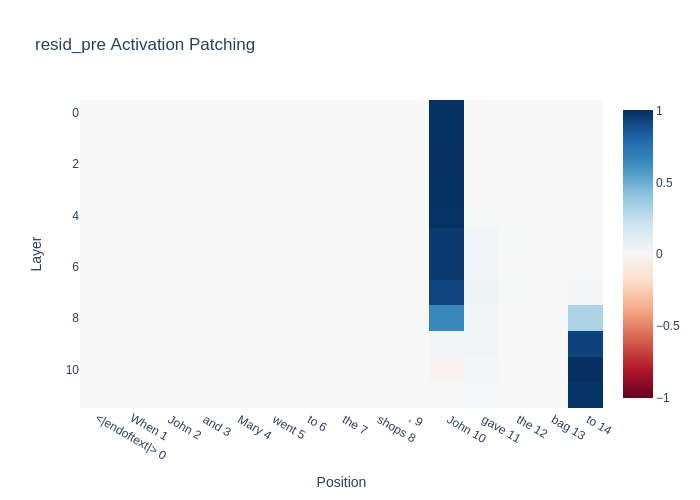

In [9]:
resid_pre_act_patch_results = patching.get_act_patch_resid_pre(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(
    resid_pre_act_patch_results,
    yaxis="Layer",
    xaxis="Position",
    x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
    title="resid_pre Activation Patching"
)

  0%|          | 0/144 [00:00<?, ?it/s]

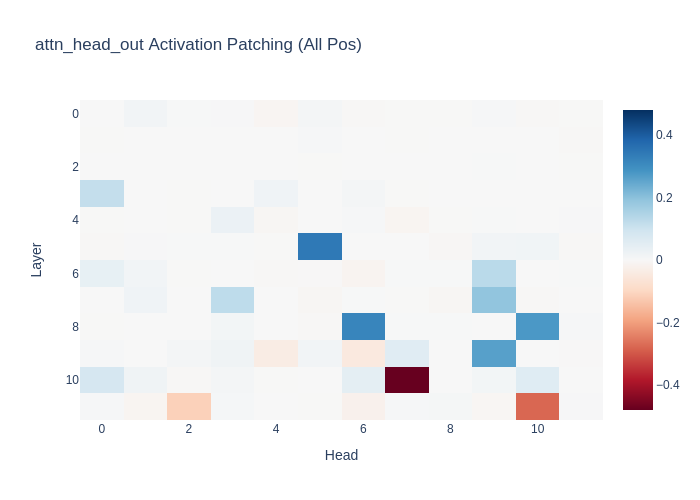

In [10]:
attn_head_out_all_pos_act_patch_results = patching.get_act_patch_attn_head_out_all_pos(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(attn_head_out_all_pos_act_patch_results,
       yaxis="Layer",
       xaxis="Head",
       title="attn_head_out Activation Patching (All Pos)"
       )